In [55]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpopulation
from gwpopulation.models.redshift import MadauDickinsonRedshift
import bilby
import seaborn as sns
import pylab as plt
import os
import h5py
from sympy import symbols
import GWForge
import pycbc
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd

# A-sharp

In [2]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp')

In [3]:
gwpop_result = bilby.result.read_in_result(filename=os.path.join(project_dir, 
                                                                 'gwpopulation', 
                                                                 'BBH', 
                                                                 'gwpop_analysis_results',
                                                                 'Asharp',
                                                                 'run01_opt_SNR_injections',
                                                                 'Asharp-study-gwpop_result.hdf5'))
posterior = gwpop_result.posterior

gwpop_result_mf_injs = bilby.result.read_in_result(filename=os.path.join(run_dir,
                                                                         'run01_mf_SNR_injections',
                                                                         'Asharp-study-gwpop_result.hdf5'))
posterior_mf = gwpop_result_mf_injs.posterior

In [4]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.481773,18.363437,4503.662922,-5.857933,2.352954
1,0.686050,17.836531,4504.028568,-5.857933,3.331604
2,0.704780,13.192570,4504.629633,-5.857933,3.305253
3,2.173684,10.521099,4505.121536,-5.857933,1.678606
4,1.599880,9.788357,4505.156158,-5.857933,2.264352
...,...,...,...,...,...
3296,1.005059,7.788476,4512.473697,-5.857933,2.193468
3297,1.074370,7.577397,4512.474685,-5.857933,2.128735
3298,0.977523,7.539598,4512.476319,-5.857933,2.188736
3299,1.017471,7.210067,4512.476638,-5.857933,2.167126


In [5]:
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            '1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td.h5'), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

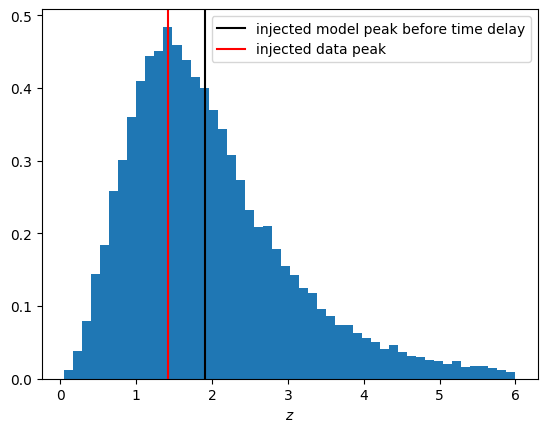

In [33]:
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(1.9, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [6]:
MDR_model = MadauDickinsonRedshift(z_max=8)

In [7]:
injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                         'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

## Opt SNR injections

### Plot model at injection params vs median params

In [34]:
median_hyper_params = {'gamma':np.median(posterior['gamma']), 
                       'kappa':np.median(posterior['kappa']), 
                       'z_peak':np.median(posterior['z_peak'])}

In [35]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 8, 0.01)
posterior_median_prob_arr = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params)

Text(0.5, 0, '$z$')

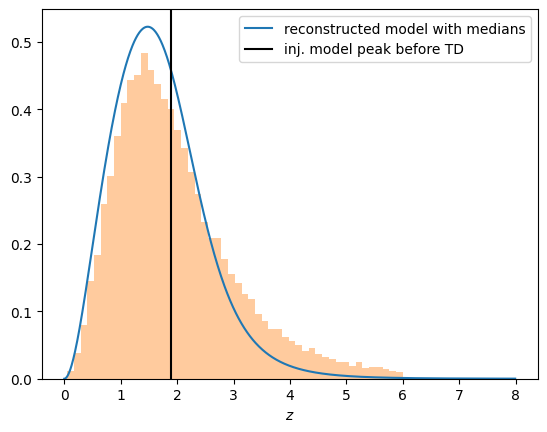

In [36]:
#plt.plot(injected_redshift[sort_idx], inj_prob_arr[sort_idx])
plt.plot(z_grid, posterior_median_prob_arr, label='reconstructed model with medians')
plt.hist(injected_redshift, bins=50, density=True, alpha=0.4);
#plt.plot(injected_redshift[sort_idx], 0.06*MDR_model.psi_of_z(injected_redshift, **injected_hyper_params['before_time_delay'])[sort_idx])
plt.axvline(1.9, c='k', label='inj. model peak before TD')
#plt.axvline(inj_z_peak, c='r', label='inj. data peak')
#plt.axvline(median_hyper_params['z_peak'], c='g')
plt.legend()
plt.xlabel('$z$')

### Plot posterior bands

In [37]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [38]:
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

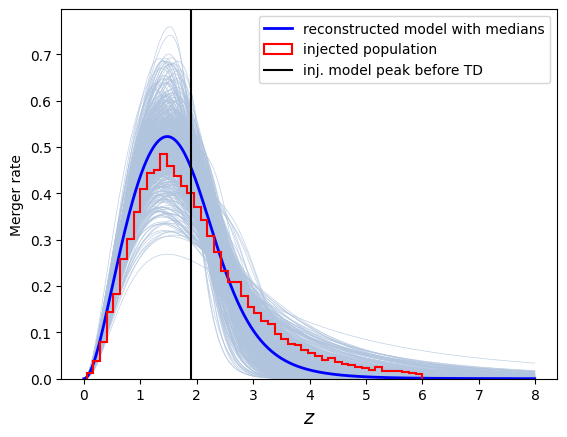

In [39]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr, label='reconstructed model with medians', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.axvline(1.9, c='k', label='inj. model peak before TD')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('Merger rate')
plt.savefig(os.path.join(plot_dir, 'reconstructed_z.pdf'))

## MF SNR injections

### Plot model at injection params vs median params

In [8]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [9]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 8, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

Text(0.5, 0, '$z$')

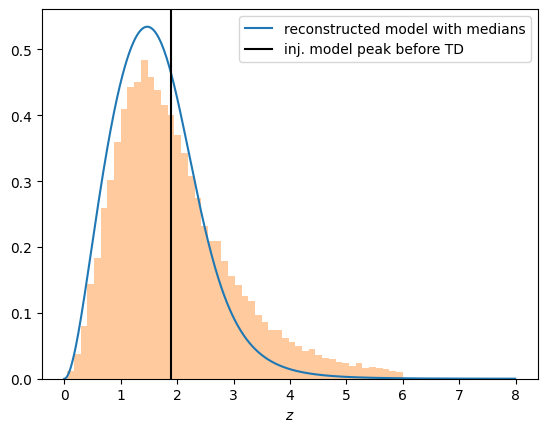

In [38]:
#plt.plot(injected_redshift[sort_idx], inj_prob_arr[sort_idx])
plt.plot(z_grid, posterior_median_prob_arr_mf, label='reconstructed model with medians')
plt.hist(injected_redshift, bins=50, density=True, alpha=0.4);
#plt.plot(injected_redshift[sort_idx], 0.06*MDR_model.psi_of_z(injected_redshift, **injected_hyper_params['before_time_delay'])[sort_idx])
plt.axvline(1.9, c='k', label='inj. model peak before TD')
#plt.axvline(inj_z_peak, c='r', label='inj. data peak')
#plt.axvline(median_hyper_params['z_peak'], c='g')
plt.legend()
plt.xlabel('$z$')

### Plot posterior bands

In [10]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [11]:
z_grid = np.arange(0, 8, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

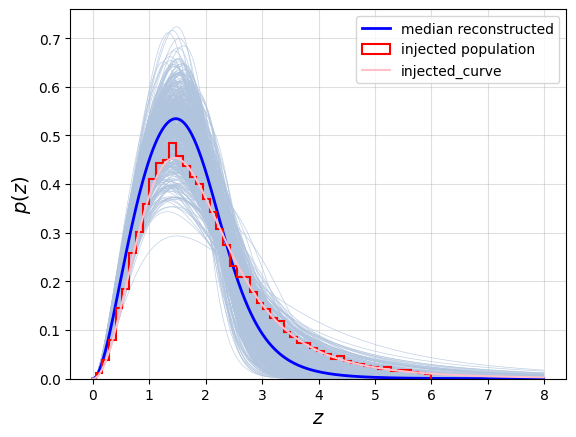

In [13]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
#plt.savefig(os.path.join(run_dir, 'run01_mf_SNR_injections', 'reconstructed_z.png'), dpi=300)

## Compare Opt SNR injs vs MF SNR injs

Text(0.5, 0, '$z$')

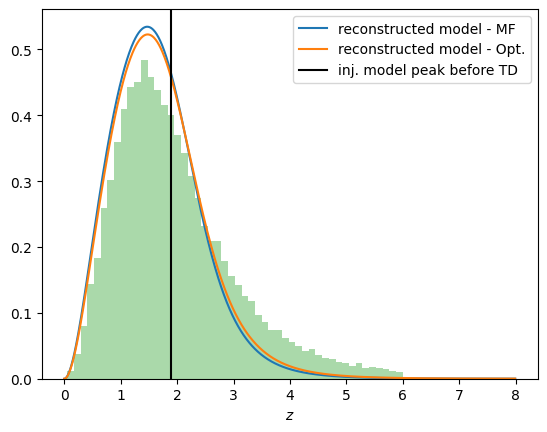

In [40]:
plt.plot(z_grid, posterior_median_prob_arr_mf, label='reconstructed model - MF')
plt.plot(z_grid, posterior_median_prob_arr, label='reconstructed model - Opt.')
plt.hist(injected_redshift, bins=50, density=True, alpha=0.4);
plt.axvline(1.9, c='k', label='inj. model peak before TD')
plt.legend()
plt.xlabel('$z$')

# CE4020ET123

In [68]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                       'CE4020ET123', 'run06_original_cov_mf_from_opt_SNR_injections')

In [69]:
gwpop_result_mf_injs = bilby.result.read_in_result(filename=os.path.join(run_dir, 
                                                                         'CE4020ET123_result.hdf5'))
posterior_mf = gwpop_result_mf_injs.posterior

In [70]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,0.786752,6.265273,10805.722859,-5.857933,2.427571
1,0.820893,5.944897,10806.271697,-5.857933,2.303298
2,0.957166,5.024338,10806.307252,-5.857933,2.306046
3,0.746543,5.042550,10806.915166,-5.857933,2.205659
4,0.900474,4.966448,10807.189807,-5.857933,2.046980
...,...,...,...,...,...
3309,1.772709,5.655901,10814.698925,-5.857933,1.809214
3310,1.754772,5.633148,10814.704275,-5.857933,1.817061
3311,1.693890,5.613660,10814.711129,-5.857933,1.836716
3312,1.691178,5.605745,10814.711214,-5.857933,1.835766


In [71]:
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            '2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

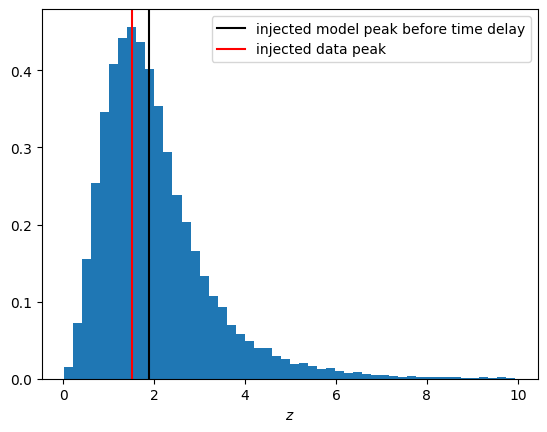

In [72]:
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(1.9, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [73]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [74]:
injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                         'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

## MF SNR injections

### Plot model at injection params vs median params

In [75]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [76]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [77]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [78]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

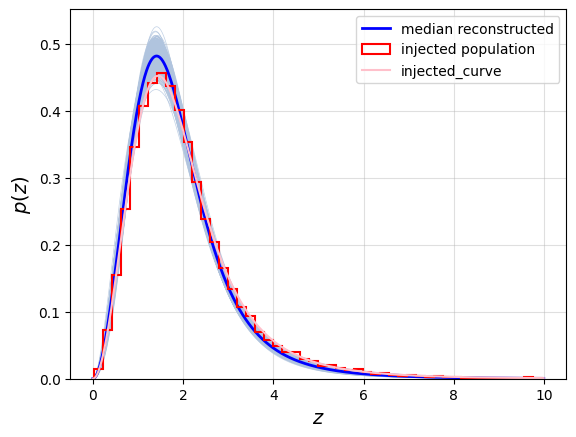

In [79]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)